# Animations

[File as PDF](https://github.com/fcichos/CBPM24/blob/7bbed8e18b859cef508e5b763a58b21aef6f7fe4/source/notebooks/L4/3_animations.pdf)

Animations are sometimes a nice feature, if you want to have a look at how your calculations evolve over time. Especially in the case of our particle based simulations it seems useful to diplay the position of the particles over time.

There are multiple ways to animate plots and images in python. Not all of them are always transferable between computers. Matplotlib for example provides a `animate` function, which can also use the `ffmpeg` video compressor. But that requires installation of all of them on the specific system you are working on. 

We want to use the `ipycanvas` module, because it delivers easy drawing of shapes like circles or rectangle in a canvas directly in our Jupyter Notebooks. Have a look at the ([documentation](https://readthedocs.org/projects/ipycanvas/downloads/pdf/latest/)). The module provides even tools to interact with a mouse.

## Import Modules

Before we start, lets have a look at the modules we import this time. Except the NumPy modules we never used them before. We import `time`, `threading`, and `ipycanvas`.

~~~
import numpy as np
from time import sleep,time
from threading import Thread

from ipycanvas import MultiCanvas, hold_canvas,Canvas
~~~


The `time` module is python standard module, which contains timing-related functions like the `sleep` and `time` function for example. 

* The function suspends execution of the current thread for a given number of seconds.
* The `time()` function returns the number of seconds passed since epoch. For Unix system, `January 1, 1970, 00:00:00` at UTC is epoch (the point where time begins).


The `threading` module is a module which allows you to specify how the processes in your notebook are executed. 


The `ipycanvas` module is the one which helps us to draw the objects of our simulation.

The following lines test if the notebook is running in google colab and install/enable ipycanvas there.

In [1]:
try:
  import google.colab
  !pip install ipycanvas==0.11
  from google.colab import output
  output.enable_custom_widget_manager()
  IN_COLAB=True
except:
  IN_COLAB = False

In [1]:
import numpy as np
from time import sleep,time
from threading import Thread
import threading 

from ipycanvas import MultiCanvas, hold_canvas,Canvas

## Particle class

We start by using out colloidal particle class, which we developed in the last section.

In [2]:
# Class definition
class Colloid:

    # A class variable, counting the number of Colloids
    number = 0
    f = 2.2e-19 # this is k_B T/(6 pi eta) in m^3/s

    # constructor
    def __init__(self,R, x0=0, y0=0):        
        # add initialisation code here
        self.R=R        
        self.x=[x0]
        self.y=[y0]
        Colloid.number=Colloid.number+1
        self.index=Colloid.number 
        self.D=Colloid.f/self.R        
        
    def get_D(self):        
        return(self.D)
    
    def sim_trajectory(self,N,dt):        
        for i in range(N):
            self.update(dt)
    
    def update(self,dt):                   
        self.x.append(self.x[-1]+np.random.normal(0.0, np.sqrt(2*self.D*dt)))
        self.y.append(self.y[-1]+np.random.normal(0.0, np.sqrt(2*self.D*dt)))
        return(self.x[-1],self.y[-1])
        
    def get_trajectory(self):
        return(pd.DataFrame({'x':self.x,'y':self.y}))
    
    # class method accessing a class variable
    @classmethod
    def how_many(cls):
        return(Colloid.number)
    
    # insert something that prints the particle position in a formatted way when printing
    def __str__(self):
        return("I'm a particle with radius R={0:0.3e} at x={1:0.3e},y={2:0.3e}.".format(self.R, self.x[-1], self.y[-1]))

## Create a set of particles 

We want to animate the Brownian motion of many particles. The best is therefore to create a `list` which contains all the individual `Colloid` objects. We start by creating 200 colloids at the position `(0,0)` to see how the spread from the origin. They are stored in the list `p`.

In [3]:
# number of particles
N=200

p=[]
for _ in range(N):
    p.append(Colloid(1*1e-6,0,0))

## Canvas and drawing function

Next, we need  a canvas, in which we draw our particles and we need the drawing function. 

The canvas is created by the `Canvas()` constructor if `ipycanvas`. The `display` command displays the canvas below the the cell.

In [4]:
canvas = Canvas(width=300, height=300)
display(canvas)

Canvas(height=300, width=300)

![particles](img/particles.png)

We realize the drawing in a `for` loop, which is first updating all particle positions and then drawing all the particles. 

The loop contains one interesting statement, which is the `with hold_canvas(canvas):`. Its useful to know that this statement halts the execution of all subsequent drawing comments in the following code block to create a "batch" of drawing commands send at one to the `ipycanvas` module. This will allow fast drawing of the whole scene.  All the rest of the commands are shortly explained in the loop comments.

In [5]:
scale=1e7 # this is to scale up all from µm to pixels
for _ in range(1000):
    for i in range(N):
        p[i].update(0.03)
        
    with hold_canvas(canvas):
        canvas.clear() # clear the canvas before drawing
        canvas.fill_style = 'red' # fill color for the particles
        canvas.global_alpha = 0.5 # make the slightly transparent
        for i in range(N): # loop over all particles
            # draw a filled circle for each particle
            canvas.fill_arc(p[i].x[-1]*scale+150, p[i].y[-1]*scale+150, 5, 0, 2*np.pi) 
        sleep(0.03) # wait 10 ms before drawing the next timestep

**Talk about the with statement next time**

## Threading for animation

It is useful to start a simulation as a background process, which is running while you keep calculating in your Jupyter notebook. This can be achieved by setting up a thread. 

A computer program is a collection of instructions. A process is the execution of those instructions. A thread is a subset of the process. A process can have one or more threads. The `Thread` function of the `threading` module can start a process in background, such that your Jupyter notbook is not blocked for the specific time the process is executed. We will talk about how to use this module later in this section.



To setup such a background process you first need to setup a function that should be executed as a thread. This is the updating and drawing of the colloidal particles. 
The `Thread()` function of the `threading` module is setting up everything for you and assigning that to the variable `simulation`. The `target=draw` statement thereby points the thread to take the right function. Once you start the thread with `simulation.start()` the function draw is executed in background until its finished. 

~~~
def draw():
    # do your drawing code here

simulation = Thread(target=draw)  

simulation.start()
~~~

That's all you need. So lets wrap all our drawing before into a draw function.


In [6]:
def draw():
    for _ in range(1000):
        for i in range(N):
            p[i].update(0.18)

        with hold_canvas(canvas):
            canvas.clear() # clear the canvas before drawing
            canvas.fill_style = 'red' # fill color for the particles
            canvas.global_alpha = 0.5 # make the slightly transparent
            for i in range(N): # loop over all particles
                # draw a filled circle for each particle
                canvas.fill_arc(p[i].x[-1]*scale+150, p[i].y[-1]*scale+150, p[i].R*1e7, 0, 2*np.pi) 
            sleep(0.03) # wait 10 ms before drawing the next timestep

In [7]:
simulation = Thread(target=draw)  

We create a new canvas here, even though we could use the one on the top. It's just nice to not have to scroll up.

In [8]:
canvas = Canvas(width=300, height=300)
display(canvas)

Canvas(height=300, width=300)


![particles](img/particles.png)

In [9]:
# start the simulation
simulation.start() 

One of the intruiging things of this type of threading is that all of the parameters of the Colloids may still be changed on the fly while the process is running. So lets just reset the particle positions to the origin and see what is happening in the canvas.

In [10]:
for i in range(N):
    p[i].x=[0]
    p[i].y=[0]

Now that we have a nice way of simulating particle motion you can extend that a bit. Here are three additions you may want to make:

1) **Introduce boundary conditions:** This is a different way of keeping the particles inside the simulation box. They are just reflected by a boundary.

2) **Introduce a drift velocity:** Particles may not only move diffusively but also with a constant drift velocity in a certain direction. We want to introduce that feature to tackle a COVID-19 spreading.

3) **Introduce collisions:** To study the spreading of an infection, we have to introduce collisions between particles.

### Threading and Stopping

Threading is nice, but gets easily confusing if running a thread multiple times without closing and stopping. You will end up with many threads that rush around somewhere in memory, which is of course not nice. Here is a small code snippet, you may want to consider, when you running your tasks in threads. It helps you to end a thread properly. 

The `self._stop_event.set()` method is used to set the internal flag of a threading.Event object to true. 

In the context of the `StoppableThread` class, `self._stop_event` is a threading.Event object that is used to signal the thread to stop executing. 

When `self._stop_event.set()` is called, it sets the internal flag of the Event object to true. The thread checks this flag in its `run` method with `self._stop_event.is_set()`. If the flag is true, the thread stops executing.

Here's a simplified explanation of how it works:

1. Initially, the `self._stop_event` flag is false.
2. When the `stop` method is called, it sets the `self._stop_event` flag to true using `self._stop_event.set()`.
3. In the `run` method, the thread continually checks whether `self._stop_event.is_set()` is true. If it is, the thread stops executing. If it's not, the thread continues to execute.

This is a common pattern for stopping a thread in Python because Python does not provide a built-in way to stop threads directly.


In [11]:
class StoppableThread(threading.Thread):
    def __init__(self):
        super().__init__()
        self._stop_event = threading.Event()

    def run(self):
        while not self._stop_event.is_set():
            print("Doing something")
            sleep(1)

    def stop(self):
        self._stop_event.set()


t = StoppableThread()
t.start()
sleep(5)  
t.stop()  
t.join() 

Doing something
Doing something
Doing something
Doing something
Doing something


## Animations with Matplotlib

While we have done all animations before with the help of the `ipywidgets` module, it is also possible to use the `matplotlib` module as well. There are several options,e.g., precalculating and displaying the animation. Yet, we want to use is the direct drawing. The code below demonstrates this option for 400 particles.

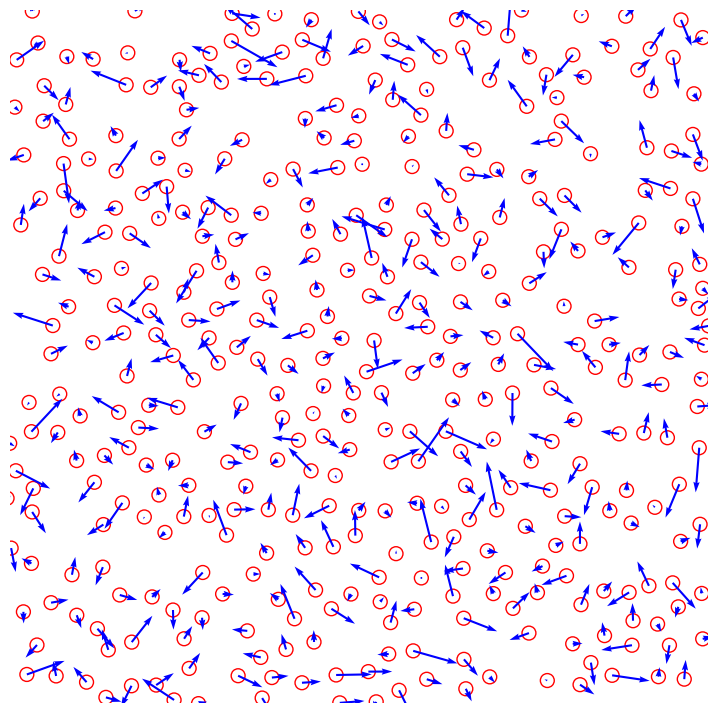

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.spatial.distance import cdist

n_side = 20

x = np.linspace(0.05, 0.95, n_side)
y = np.linspace(0.05, 0.95, n_side)
xx, yy = np.meshgrid(x, y)
particles = np.vstack([xx.ravel(), yy.ravel()]).T

velocities = np.random.normal(scale=0.005, size=(n_side**2, 2))

radius = 0.0177
fig, ax = plt.subplots(figsize=(9,9))

n_steps = 200

for _ in range(n_steps):
    clear_output(wait=True)
    
    particles += velocities    
    particles[:, 0] = particles[:, 0] % 1    
    particles[:, 1] = particles[:, 1] % 1    
    distances = cdist(particles, particles)
    
    collisions = np.triu(distances < 2*radius, 1)
    
    for i, j in zip(*np.nonzero(collisions)):
        velocities[i], velocities[j] = velocities[j], velocities[i].copy()
        
        overlap = 2*radius - distances[i, j]
        direction = particles[i] - particles[j]
        direction /= np.linalg.norm(direction)
        particles[i] += 0.5 * overlap * direction
        particles[j] -= 0.5 * overlap * direction
    
    ax.scatter(particles[:, 0], particles[:, 1], s=100, edgecolors='r', facecolors='none')
    ax.quiver(particles[:, 0], particles[:, 1], velocities[:, 0], velocities[:, 1], color='b')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")
    
    display(fig)    
    plt.pause(0.01)    
    ax.clear()